### Initial setup

In [1]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
import daft

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import theano
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import missingno
import graphviz
from causalgraphicalmodels import CausalGraphicalModel

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Packages uploaded successfully!


In [2]:
#Read dataset
data = pd.read_csv('./machine_readable_dnt.csv')

### Data standardisation

In [3]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID','Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

### Model definition and fitting


$$
DNT \sim Bernoulli(\sum(BDNF+SYN+NNF))

$$
$$
BDNF \sim Bernoulli (logit(p_{BDNF}), \mu, \sigma)\\
SYN \sim Bernoulli (logit(p_{SYN}), \mu, \sigma)\\
NNF \sim Bernoulli (logit(p_{NNF}), \mu, \sigma)\\
$$
$$
logit(p_{BDNF}) = \beta_{BDNF} * X_{BDNF} \\ 
logit(p_{SYN}) = \beta_{SYN} * X_{SYN} \\ 
logit(p_{NNF}) = \beta_{NNF} * X_{NNF} \\ 
$$
$$
X_{BDNF}: SLogP, Cbrain/Cblood, BBB, Pgp_{inhibition}, Pgp_{substrate}, Pgp_{active}\\
X_{SYN}: Syn_{EC30}, Viability_{EC30}\\
X_{NNF}: NNF_{EC50min}, NNF_{EC50max}, Viability_{LDH}\\
$$
$$
\beta_{BDNF}, \beta_{SYN}, \beta_{NNF} \sim Normal(\mu, \sigma) \\
\mu \sim Normal (0, 1) \\
\sigma \sim HalfNormal (0.5) \\
$$
$$
KER(\%) = \frac{KE_n + KE_{n+1}}{KE_n}*100
$$

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data[['DNT']]).values


In [5]:
# ### Mask missing values

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(y_dnt)
Y_dnt_train = np.ma.masked_array(y_dnt, mask=y_dnt_missing)

In [15]:
# ### Define and fit the model
with pm.Model() as hierar_model:
    #Define hyperpriors
    µ_β = pm.Normal('µ_β', mu=0, sd=1)
    σ_β = pm.HalfNormal('σ_β', sd=0.5) 
    #Define priors
    β_bdnf = pm.Normal('beta_bdnf', mu=µ_β, sigma=σ_β, shape=(6,1))
    β_syn = pm.Normal('beta_syn', mu=µ_β, sigma=σ_β, shape=(2,1))
    β_nnf = pm.Normal('beta_nnf', mu=µ_β, sigma=σ_β, shape=(3,1))

In [7]:
# ## Define bndf 
with hierar_model: 
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=0.5, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', mu=Xmu_bdnf, sd=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf',  pm.math.dot(X_bdnf_modelled, β_bdnf)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [8]:
# ## Define syn
with hierar_model:
    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=0.5, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', y_obs_bdnf + pm.math.dot(X_syn_modelled, β_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p = lp_syn, observed=Y_syn_train)


In [9]:
# ## Define nnf
with hierar_model:
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=0.5, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', y_obs_syn + pm.math.dot(X_nnf_modelled, β_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)


In [10]:
# ## Define DNT
with hierar_model:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', y_obs_bdnf + y_obs_syn + y_obs_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)


In [11]:
# ##KERs
with hierar_model:
    #Define percentage change of KERs
    perc_change_ker1 = pm.Deterministic('perc_change_ker1', 
                                   100 * (y_obs_bdnf - y_obs_syn) / y_obs_bdnf)
    perc_change_ker2 = pm.Deterministic('perc_change_ker2', 
                                   100 * (y_obs_syn - y_obs_nnf) / y_obs_syn)
    perc_change_ker3 = pm.Deterministic('perc_change_ker3', 
                                   100 * (y_obs_nnf - y_obs_dnt) / y_obs_nnf)
    perc_change_ker4 = pm.Deterministic('perc_change_ker4', 
                                   100 * (y_obs_bdnf - y_obs_dnt) / y_obs_bdnf)


In [12]:
#Checking the model
hierar_model.check_test_point()

mu_beta                     -0.92
sd_beta_log__               -0.77
beta_bdnf                   -0.00
beta_syn                    -0.00
beta_nnf                    -0.00
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     -2.76
Xsigma_nnf_log__            -2.31
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -901.64
y_obs_bdnf                 -67.24
X_syn_modelled            -201.06
y_obs_syn                  -67.88
X_nnf_modelled            -512.08
y_obs_nnf                  -62.94
y_obs_dnt                  -46.08
Name: Log-probability of test_point, dtype: float64

In [14]:
with hierar_model:
    trace = pm.sample(cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2087 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'mu_beta'}>,
        <AxesSubplot:title={'center':'mu_beta'}>]], dtype=object)

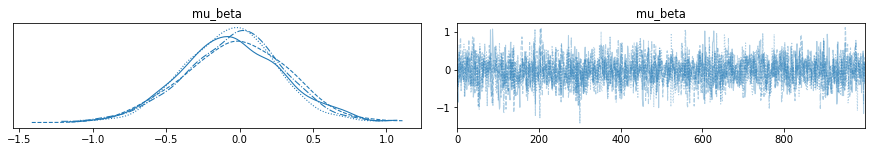

In [18]:
#Checking the inferences
pm.traceplot(trace, var_names=['mu_beta'])

In [ ]:
pm.traceplot(trace, var_names=['lp_bdnf'])

<AxesSubplot:>

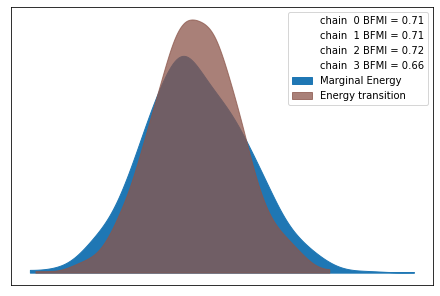

In [19]:
#Diagnostic plot
pm.plots.energyplot(trace)

In [ ]:
#Graphical representation
pm.model_to_graphviz(hierar_model)

In [ ]:
#Plot of outcomes
pm.plot_posterior(trace)

In [ ]:
#Statistical summary
pm.summary(trace, round_to=2)

In [ ]:
#Forest plots
pm.plot_forest(trace)